In [ ]:
'''
Code repurposed from
https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm
'''

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import gensim

import scikitplot.metrics as skplt

import nltk

from xgboost import XGBClassifier

import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
#--Reading the data
df = pd.read_csv('C:/Users/Matthew.000/OneDrive/Documents/2020 Autumn/AI-Analytics Capstone Project/UTS/incidents_2010_2019.csv', encoding = 'ANSI')

#--Trimming unnecessary columns
df = df[['IncidentCause', 'EventDescription', 'Category']]

#--Replacing 'other' with 'Other' in 'Category'
df['Category'] = df['Category'].replace('other', 'Other')

#--Replacing 'AF other' with 'AF Other' in 'Category'
df['Category'] = df['Category'].replace('AF other', 'AF Other')

#--Replacing 'OH cable' with 'OH Cable' in 'Category'
df['Category'] = df['Category'].replace('OH cable', 'OH Cable')

#--Replacing 'Dug up' with 'Dug Up' in 'Category'
df['Category'] = df['Category'].replace('Dug up', 'Dug Up')

#--Replacing NULL values with empty strings in 'IncidentCause' and 'EventDescription'
df['IncidentCause'] = df['IncidentCause'].replace(np.nan, '')
df['EventDescription'] = df['EventDescription'].replace(np.nan, '')

#--Removing rows with 'Not reportable - delete' in 'Category'
df = df[df['Category'] != 'Not reportable - delete']

#--Removing rows with NaN in 'Category'
df = df[df['Category'].notnull()]

df = df.reset_index()

In [14]:
#--Creating a new column by merging the IncidentCause and EventDescripion columns
df['processed_text'] = df['IncidentCause'] + ' ' + df['EventDescription']

df.head()

index                                      IncidentCause  \
0      0                                                      
1      1                                                      
2      2                                                      
3      3                                          line down   
4      4  PROPERTY DAMAGE - EG... CAR INTO POLE / TRUCK ...   

                                    EventDescription   Category  \
0  SCHEDULE 1<br /> <br /> Fault crew was patroll...  Lightning   
1  SCHEDULE TWO<br /> <br /> Mrs Atkinson was dre...  Lightning   
2  SCHEDULE ONE<br /> <br /> Lightning hit tree i...  Lightning   
3                           public reports line down  Conductor   
4  NRC ID : 166179.00000 NRC Priority: PRIORITY 2...   AF Other   

                                      processed_text  
0   SCHEDULE 1<br /> <br /> Fault crew was patrol...  
1   SCHEDULE TWO<br /> <br /> Mrs Atkinson was dr...  
2   SCHEDULE ONE<br /> <br /> Lightning hit tree ...  
3                 line down public reports line down  
4  PROPERTY DAMAGE - EG... CAR INTO POLE / TRUCK ...

In [27]:
#--Splitting the data into 70% training, 30% testing
x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['Category'], test_size = 0.3)
x_test = x_test.to_frame()

In [28]:
xy_train = pd.concat([x_train, y_train], axis = 1).reset_index()

xy_train.head()

index                                     processed_text      Category
0   8814  HV isolator heating due to fault further downs...    Connection
1   8595  Localised corrosion of the steel conductor. IM...     Conductor
2   3691  PRIVATE OVERHEAD ELECTRIC LINE ISSUES NRC ID :...      OH Cable
3  11810  Earth bonding issue with installation plumbing...  Installation
4   7906  Crew unable to determine cause MFB reported a ...      AF Other

In [29]:
xy_train.describe(include = 'all')

index                                     processed_text  \
count   10507.000000                                              10507   
unique           NaN                                              10480   
top              NaN  Excessive leakage current Customer reported po...   
freq             NaN                                                  3   
mean     7512.953840                                                NaN   
std      4329.631655                                                NaN   
min         0.000000                                                NaN   
25%      3736.500000                                                NaN   
50%      7548.000000                                                NaN   
75%     11242.500000                                                NaN   
max     15009.000000                                                NaN   

          Category  
count        10507  
unique          15  
top     Connection  
freq          1492  
mean           NaN  
std            NaN  
min            NaN  
25%            NaN  
50%            NaN  
75%            NaN  
max            NaN

In [32]:
x_test.head()

processed_text
3022   EDo malfunctioned SCHEDULE ONE<br /> <br /> ED...
13507  Pole fire A field crew attending an outage fou...
13486  Excessive leakage current Crew were in the are...
14453  Tractor hit service line A customer reported t...
10878  A deterioated copper neutral screen service wa...

In [31]:
x_test.describe(include = 'all')

processed_text
count                                                4504
unique                                               4500
top     Earth cable theft A contract employee  reporte...
freq                                                    2

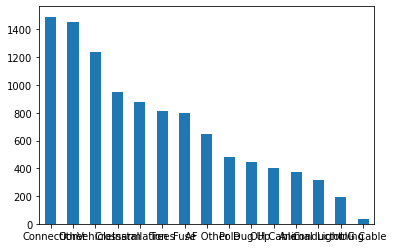

In [33]:
xy_train['Category'].value_counts().plot(kind = "bar", rot = 0)

In [41]:
def evaluate_features(X, y, clf = None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv = StratifiedKFold(random_state = 8), 
                              n_jobs = -1, method='predict_proba', verbose = 2)
    pred_indices = np.argmax(probas, axis = 1)
    categories = np.unique(y)
    preds = categories[pred_indices]
    print(f'Log loss: {log_loss(y, probas)}')
    print(f'Accuracy: {accuracy_score(y, preds)}')
    skplt.plot_confusion_matrix(y, preds)


In [42]:
#Bag of Words

In [43]:
count_vectorizer = CountVectorizer(
    analyzer = "word", tokenizer = nltk.word_tokenize,
    preprocessor = None, stop_words = 'english', max_features = None)

In [44]:
bag_of_words = count_vectorizer.fit_transform(xy_train['processed_text'])

In [45]:
len(count_vectorizer.get_feature_names())

28906

In [114]:
svd = TruncatedSVD(n_components = 25, n_iter = 25, random_state = 12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.2884535703093227
Accuracy: 0.6150185590558676


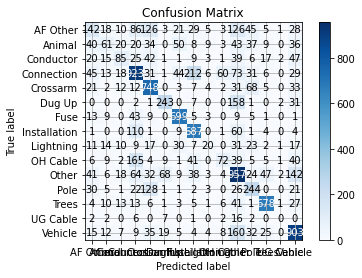

In [115]:
evaluate_features(truncated_bag_of_words, xy_train['Category'].values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.6s remaining:   25.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.9s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.7724618591935617
Accuracy: 0.505567716760255


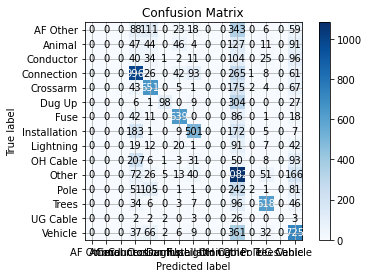

In [116]:
evaluate_features(truncated_bag_of_words, xy_train['Category'].values.ravel(), 
                  RandomForestClassifier(n_estimators = 1000, max_depth = 5, verbose = 1))

In [ ]:
#TF-IDF

In [51]:
count_vectorizer = TfidfVectorizer(
    analyzer = "word", tokenizer = nltk.word_tokenize,
    preprocessor = None, stop_words = 'english', max_features = None)

In [111]:
tfidf = count_vectorizer.fit_transform(xy_train['processed_text'])

In [112]:
len(count_vectorizer.get_feature_names())

28906

In [54]:
svd = TruncatedSVD(n_components = 25, n_iter = 25, random_state = 12)
truncated_tfidf = svd.fit_transform(tfidf)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.1009109205934846
Accuracy: 0.686685067098125


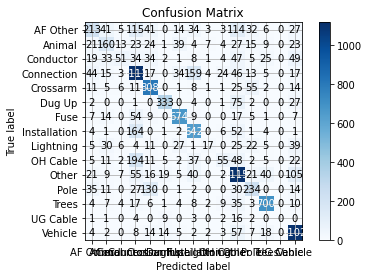

In [55]:
evaluate_features(truncated_tfidf, xy_train['Category'].values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   16.7s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.4907409288848283
Accuracy: 0.6085466831636052


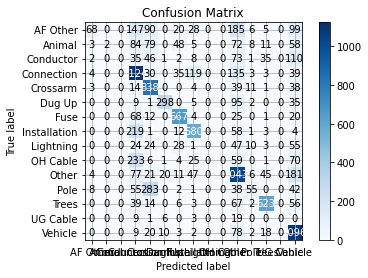

In [56]:
evaluate_features(truncated_tfidf, xy_train['Category'].values.ravel(), 
                  RandomForestClassifier(n_estimators = 1000, max_depth = 5, verbose = 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.7min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 0.7384093118708549
Accuracy: 0.7738650423527172


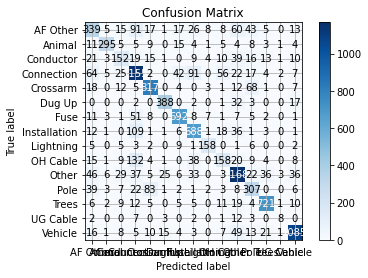

In [57]:
evaluate_features(tfidf, xy_train['Category'].values.ravel(), 
                  SVC(kernel = 'linear', probability = True))

In [ ]:
#word2vec

In [58]:
class MySentences(object):
    """MySentences is a generator to produce a list of tokenized sentences 
    
    Takes a list of numpy arrays containing documents.
    
    Args:
        arrays: List of arrays, where each element in the array contains a document.
    """
    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in nltk.sent_tokenize(document):
                    yield nltk.word_tokenize(sent)

def get_word2vec(sentences, location):
    """Returns trained word2vec
    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load word2vec
    """
    if os.path.exists(location):
        print(f'Found {format(location)}')
        model = gensim.models.Word2Vec.load(location)
        return model
    
    print(f'{format(location)} not found. training model')
    model = gensim.models.Word2Vec(sentences, size = 100, window = 5, min_count = 5, workers = 4)
    print('Model done training. Saving to disk')
    model.save(location)
    return model

In [60]:
w2vec = get_word2vec(
    MySentences(
        xy_train['processed_text'].values, 
        x_test['processed_text'].values
    ),
    'w2vmodel'
)

w2vmodel not found. training model
Model done training. Saving to disk


In [66]:
class MyTokenizer:
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        transformed_X = []
        for document in X:
            tokenized_doc = []
            for sent in nltk.sent_tokenize(document):
                tokenized_doc += nltk.word_tokenize(sent)
            transformed_X.append(np.array(tokenized_doc))
        return np.array(transformed_X)
    
    def fit_transform(self, X, y = None):
        return self.transform(X)

class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        #self.dim = len(word2vec.wv.syn0[0])
        self.dim = len(word2vec.wv.vectors[0])

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        X = MyTokenizer().fit_transform(X)
        
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv]
                    or [np.zeros(self.dim)], axis = 0)
            for words in X
        ])
    
    def fit_transform(self, X, y = None):
        return self.transform(X)

In [67]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(w2vec)
mean_embedded = mean_embedding_vectorizer.fit_transform(xy_train['processed_text'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.1246429056585963
Accuracy: 0.6551822594460835


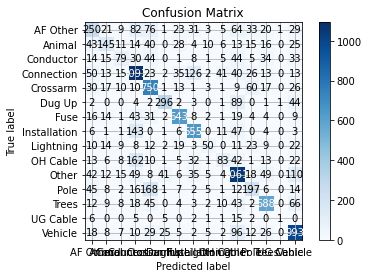

In [70]:
evaluate_features(mean_embedded, xy_train['Category'].values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.3390334630931875
Accuracy: 0.6074997620633863


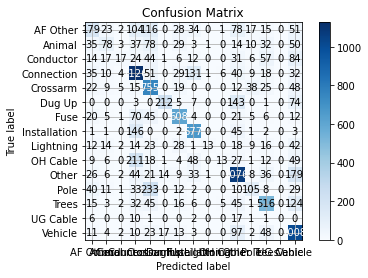

In [71]:
evaluate_features(mean_embedded, xy_train['Category'].values.ravel(),
                  RandomForestClassifier(n_estimators = 1000, max_depth = 15, verbose = 1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.3973489920436297
Accuracy: 0.5889407061958695


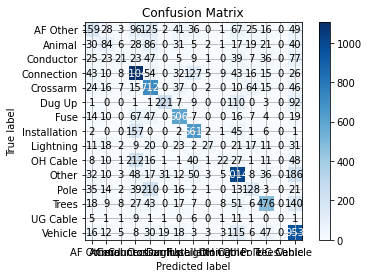

In [73]:
evaluate_features(mean_embedded, 
                  xy_train['Category'].values.ravel(),
                  XGBClassifier(max_depth = 4,
                                objective = 'multi:softprob',
                                learning_rate = 0.03333,
                                )
                 )

In [ ]:
#LTSM

In [98]:
# Use the Keras tokenizer
#num_words = 2000
tokenizer = Tokenizer()#num_words = num_words)
tokenizer.fit_on_texts(xy_train['processed_text'].values)

In [102]:
# Pad the data 
X = tokenizer.texts_to_sequences(xy_train['processed_text'].values)
X = pad_sequences(X)#, maxlen=2000)

In [105]:
# Build out our simple LSTM
embed_dim = 128
lstm_out = 196

# Model saving callback
ckpt_callback = ModelCheckpoint('keras_model', 
                                 monitor = 'val_loss', 
                                 verbose = 1, 
                                 save_best_only = True, 
                                 mode = 'auto')

model = Sequential()
model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_out, recurrent_dropout = 0.2, dropout = 0.2))
model.add(Dense(15, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_crossentropy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 932, 128)          256000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_3 (Dense)              (None, 15)                2955      
Total params: 513,755
Trainable params: 513,755
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
Y = pd.get_dummies(xy_train['Category']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(8405, 2000) (8405, 15)
(2102, 2000) (2102, 15)


In [82]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 1, batch_size = batch_size, validation_split = 0.2, callbacks = [ckpt_callback])

Train on 6724 samples, validate on 1681 samples
Epoch 1/1
6724/6724 [==============================] - 3475s 517ms/step - loss: 1.9761 - categorical_crossentropy: 1.9761 - val_loss: 1.7073 - val_categorical_crossentropy: 1.7073

Epoch 00001: val_loss improved from inf to 1.70729, saving model to keras_model


In [83]:
model = load_model('keras_model')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [84]:
probas = model.predict(X_test)

Log loss: 1.7126872799900688
Accuracy: 0.4386298763082778


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


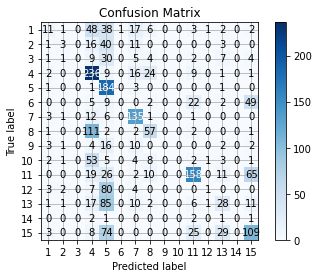

In [86]:
pred_indices = np.argmax(probas, axis = 1)
classes = np.array(range(1, 16))
preds = classes[pred_indices]
print(f'Log loss: {log_loss(classes[np.argmax(Y_test, axis = 1)], probas)}')
print(f'Accuracy: {accuracy_score(classes[np.argmax(Y_test, axis = 1)], preds)}')
skplt.plot_confusion_matrix(classes[np.argmax(Y_test, axis = 1)], preds)